In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle

In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

1.Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.

In [6]:
query1 = '''select film_id, title, release_year, l.name as language, rental_duration, rental_rate, length, rating, 
special_features, c.name as category
from film 
join language l using(language_id)
join film_category fc using(film_id)
join category c using(category_id)
    ;
;
'''
pd.read_sql_query(query1, engine)


,film_id,release_year,language,rental_duration,rental_rate,length,rating,special_features,category
0,19,2006,English,6,0.99,113,PG,"Commentaries,Deleted Scenes,Behind the Scenes",Action
1,21,2006,English,3,4.99,129,R,"Commentaries,Behind the Scenes",Action
2,29,2006,English,5,2.99,168,NC-17,"Trailers,Commentaries,Deleted Scenes",Action
3,38,2006,English,6,0.99,68,NC-17,"Trailers,Commentaries,Deleted Scenes,Behind th...",Action
4,56,2006,English,6,2.99,129,G,"Trailers,Commentaries",Action
...,...,...,...,...,...,...,...,...,...
995,931,2006,English,7,0.99,48,PG-13,"Trailers,Behind the Scenes",Travel
996,977,2006,English,3,2.99,85,R,"Deleted Scenes,Behind the Scenes",Travel
997,981,2006,English,7,0.99,55,NC-17,Behind the Scenes,Travel
998,988,2006,English,7,2.99,139,R,"Trailers,Commentaries,Behind the Scenes",Travel


2.Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005). This would be our target variable.

In [7]:
query = '''select film_id, max(august_rental) as rented, count(august_rental) as frequency
from inventory
right join(
	select inventory_id, (rental_date between '2005-08-01' and '2005-09-01') as august_rental
	from rental) t1
using(inventory_id)
group by film_id
'''
pd.read_sql_query(query, engine)

,film_id,rented,frequency
0,80,1,12
1,333,1,17
2,373,1,16
3,535,1,20
4,450,1,30
...,...,...,...
953,485,1,6
954,939,1,8
955,904,1,4
956,400,1,4


In [4]:
query = '''select film_id, release_year, l.name as language, rental_duration, rental_rate, length, 
rating, special_features, c.name as category, august_rental, past_rentals
from film
left join inventory using(film_id)
left join language l using(language_id)
left join film_category using(film_id)
left join category c using(category_id)
left join
(select film_id, past_rentals, august_rental
from
(select film_id, count(rental_history) as past_rentals
from inventory
	join (
			select inventory_id, rental_date as rental_history
			from rental
			having rental_date < '2005-08-01') t1
		using(inventory_id)
		group by film_id) t2
	join 
		(select film_id, max(rented) as august_rental
		from inventory
		join (
			select inventory_id, (rental_date between '2005-08-01' and '2005-09-01') as rented
			from rental) t3
		using(inventory_id)
		group by film_id) t4
	using(film_id)
	group by film_id) t5
using(film_id)
group by film_id, category    
;
'''

3.Read the data into a Pandas dataframe.

In [5]:
data = pd.read_sql_query(query, engine)
data

,film_id,release_year,language,rental_duration,rental_rate,length,rating,special_features,category,august_rental,past_rentals
0,1,2006,English,6,0.99,86,PG,"Deleted Scenes,Behind the Scenes",Documentary,1.0,14.0
1,2,2006,English,3,4.99,48,G,"Trailers,Deleted Scenes",Horror,1.0,2.0
2,3,2006,English,7,2.99,50,NC-17,"Trailers,Deleted Scenes",Documentary,1.0,6.0
3,4,2006,English,5,2.99,117,G,"Commentaries,Behind the Scenes",Horror,1.0,16.0
4,5,2006,English,6,2.99,130,G,Deleted Scenes,Family,1.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...
995,996,2006,English,6,0.99,183,G,"Trailers,Behind the Scenes",Documentary,1.0,4.0
996,997,2006,English,4,0.99,179,NC-17,"Trailers,Behind the Scenes",Music,1.0,3.0
997,998,2006,English,6,0.99,105,NC-17,Deleted Scenes,Horror,1.0,6.0
998,999,2006,English,5,2.99,101,R,"Trailers,Deleted Scenes",Children,1.0,10.0


4.Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [61]:
#data.category.value_counts()
#data.rating.value_counts()
#data.release_year.value_counts()  #all are 2006, drop column
#data.length.value_counts()
#data.language.value_counts()    #all are English, drop column
#data.rental_rate.value_counts()     #change to categorical
#data.rental_duration.value_counts()   #change to categorical
data.special_features.value_counts()   #split special features?

Trailers,Commentaries,Behind the Scenes                   1311
Trailers                                                  1140
Trailers,Commentaries                                     1134
Trailers,Behind the Scenes                                1127
Behind the Scenes                                         1110
Commentaries,Deleted Scenes,Behind the Scenes             1102
Commentaries                                              1090
Commentaries,Behind the Scenes                            1078
Trailers,Deleted Scenes                                   1048
Deleted Scenes,Behind the Scenes                          1039
Deleted Scenes                                            1027
Commentaries,Deleted Scenes                               1014
Trailers,Commentaries,Deleted Scenes,Behind the Scenes     989
Trailers,Commentaries,Deleted Scenes                       920
Trailers,Deleted Scenes,Behind the Scenes                  775
Name: special_features, dtype: int64

In [6]:
data.isnull().sum()

film_id              0
release_year         0
language             0
rental_duration      0
rental_rate          0
length               0
rating               0
special_features     0
category             0
august_rental       42
past_rentals        42
dtype: int64

In [10]:
#for all NaN values in august_rental and past_rental column(for films in inventory with no rental history) 
#I am filling with 0 as they were also not rented in August 2005
data.august_rental = data.august_rental.fillna(0)
data.past_rentals = data.past_rentals.fillna(0)

In [11]:
data.drop(['film_id'], axis=1, inplace=True) 

In [12]:
#dropping release_year and language columns as all values are the same
data.drop(['release_year', 'language'], axis=1, inplace=True) 

In [13]:
#changing rental_rate and rental_duration to a categorical value
data['rental_rate'] = data['rental_rate'].astype('object')
data['rental_duration'] = data['rental_duration'].astype('object')

In [14]:
#splitting special_features into categories: trailer, commentaries, behind the scenes, deleted scenes

def make_trailer(x):
    if 'Trailers' in x.split(','):
        return 1

def make_commentaries(x):
    if 'Commentaries' in x.split(','):
        return 1
    
def make_behindts(x):
    if 'Behind the Scenes' in x.split(','):
        return 1

def make_deletedscenes(x):
    if 'Deleted Scenes' in x.split(','):
        return 1

In [15]:
data['trailers'] = list(map(make_trailer, data.special_features))
data['commentaries'] = list(map(make_commentaries, data.special_features))
data['behind_the_scenes'] = list(map(make_behindts, data.special_features))
data['deleted_scenes'] = list(map(make_deletedscenes, data.special_features))

data['trailers'] = data['trailers'].fillna(0)
data['commentaries'] = data['commentaries'].fillna(0)
data['behind_the_scenes'] = data['behind_the_scenes'].fillna(0)
data['deleted_scenes'] = data['deleted_scenes'].fillna(0)

In [16]:
data.drop(['special_features'], axis=1, inplace=True)

In [17]:
data.head()

,rental_duration,rental_rate,length,rating,category,august_rental,past_rentals,trailers,commentaries,behind_the_scenes,deleted_scenes
0,6,0.99,86,PG,Documentary,1.0,14.0,0.0,0.0,1.0,1.0
1,3,4.99,48,G,Horror,1.0,2.0,1.0,0.0,0.0,1.0
2,7,2.99,50,NC-17,Documentary,1.0,6.0,1.0,0.0,0.0,1.0
3,5,2.99,117,G,Horror,1.0,16.0,0.0,1.0,1.0,0.0
4,6,2.99,130,G,Family,1.0,8.0,0.0,0.0,0.0,1.0


In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
length,1000.0,115.272,40.426332,46.0,80.0,114.0,149.25,185.0
august_rental,1000.0,0.958,0.200690,0.0,1.0,1.0,1.00,1.0
past_rentals,1000.0,10.176,5.057925,0.0,7.0,10.0,14.00,25.0
trailers,1000.0,0.535,0.499023,0.0,0.0,1.0,1.00,1.0
commentaries,1000.0,0.539,0.498726,0.0,0.0,1.0,1.00,1.0
behind_the_scenes,1000.0,0.538,0.498803,0.0,0.0,1.0,1.00,1.0
deleted_scenes,1000.0,0.503,0.500241,0.0,0.0,1.0,1.00,1.0


In [19]:
data.dtypes

rental_duration       object
rental_rate           object
length                 int64
rating                object
category              object
august_rental        float64
past_rentals         float64
trailers             float64
commentaries         float64
behind_the_scenes    float64
deleted_scenes       float64
dtype: object

In [20]:
#x-y split
y = data['august_rental']
X = data.drop(['august_rental'], axis=1)

In [21]:
# train test split 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
#minmaxscale numerical columns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

numerical = X_train.select_dtypes(include = np.number)
transformer = MinMaxScaler().fit(numerical)
x_normalized = transformer.transform(numerical)
num_transformed = pd.DataFrame(x_normalized, columns = numerical.columns)

In [49]:
#encode categories:  category, rating, rental_rate, rental_duration
#get_dummies

In [23]:
cat = X_train.select_dtypes(include = object)

cat_encoded = pd.get_dummies(cat, 
                             columns=['category', 'rating', 'rental_rate', 'rental_duration'],
                             drop_first=True)
cat_encoded.head()

,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,...,rating_NC-17,rating_PG,rating_PG-13,rating_R,rental_rate_2.99,rental_rate_4.99,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7
29,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,1,0,0,0
535,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
695,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
557,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
836,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0


In [24]:
Xtrain_transformed = np.concatenate((num_transformed, cat_encoded), axis=1)

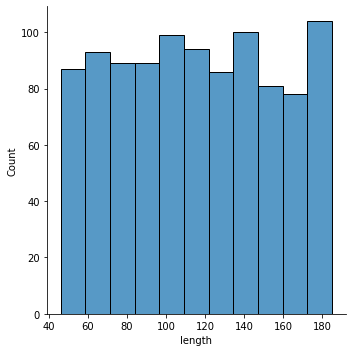

In [25]:
sns.displot(data['length'])
plt.show()

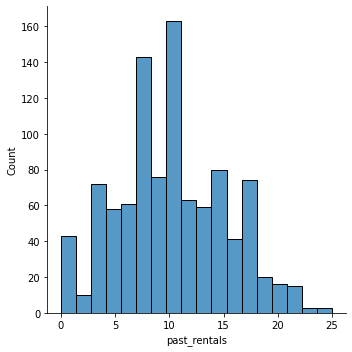

In [26]:
sns.displot(data['past_rentals'])
plt.show()

5.Create a logistic regression model to predict this variable from the cleaned data.

In [27]:
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(Xtrain_transformed, y_train)

In [ ]:
#now transform X_test data 

In [28]:
#scale numerical
num_test = X_test.select_dtypes(include = np.number)

xtest_normalized = transformer.transform(num_test)
numtest_scaled= pd.DataFrame(xtest_normalized, columns = numerical.columns)

In [29]:
#encode categorical
cat_test = X_test.select_dtypes(include = object)

cattest_encoded = pd.get_dummies(cat_test, 
                             columns=['category', 'rating', 'rental_rate', 'rental_duration'],
                             drop_first=True)

In [30]:
Xtest_transformed = np.concatenate((numtest_scaled, cattest_encoded), axis=1)

In [31]:
predictions = classification.predict(Xtest_transformed)

6.Evaluate the results.

In [32]:
classification.score(Xtest_transformed, y_test)
#score .955

0.955

In [33]:
print(y_test.value_counts())

1.0    191
0.0      9
Name: august_rental, dtype: int64


In [34]:
pd.Series(predictions).value_counts()

1.0    200
dtype: int64

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[  0,   9],
       [  0, 191]])

In [ ]:
#trying KNN instead of logistic regression

In [37]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform') 
clf.fit(Xtrain_transformed, y_train)                                       
predictions_clf = clf.predict(Xtest_transformed)
clf.score(Xtest_transformed, y_test)

#score .955

0.955

In [38]:
print(y_test.value_counts())

1.0    191
0.0      9
Name: august_rental, dtype: int64


In [39]:
pd.Series(predictions_clf).value_counts()

1.0    200
dtype: int64

In [40]:
confusion_matrix(y_test, predictions_clf)

array([[  0,   9],
       [  0, 191]])

In [41]:
#predicting all movies will be rented, not a great model...

There are 1000 movie titles in the inventory and 952 of those were rented during August 2005. The models are scoring high, but it is because the data is unbalanced. 